# Changes in aerobic habitat

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean

import data_collections as dc
import funnel
import util

In [79]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='25GB')
    cluster.scale(6)
client    

<Client: 'tcp://10.12.206.55:38932' processes=6 threads=6, memory=139.68 GiB>

In [80]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,33
variable,7
name,1
path,415


In [81]:
def fix_dataset(ds):
    ds['depth_habitat_trait_wgt'] = ds.depth_habitat_trait_wgt.where(ds.KMT > 0)
    return ds.set_coords(['TLAT', 'TLONG'])

cat = catalog.search(variable='depth_habitat_trait_wgt')
dsets = cat.to_dataset_dict(preprocess=fix_dataset, zarr_kwargs={'use_cftime': True})
dsets = {k: ds.drop(['Ac', 'Eo']) for k, ds in dsets.items()}


exp_keys = ['20C.ocn.pop.h.drift-corrected', 'RCP85.ocn.pop.h.drift-corrected']
ds = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal')
ds['TLAT'] = ds.TLAT[0, :, :]
ds['TLONG'] = ds.TLONG[0, :, :]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


,Array,Chunk
Bytes,63.63 GiB,11.25 MiB
Shape,"(32, 2172, 384, 320)","(1, 12, 384, 320)"
Count,29216 Tasks,5792 Chunks
Type,float64,numpy.ndarray


In [82]:
ds.depth_habitat_trait_wgt

,Array,Chunk
Bytes,63.63 GiB,11.25 MiB
Shape,"(32, 2172, 384, 320)","(1, 12, 384, 320)"
Count,29216 Tasks,5792 Chunks
Type,float64,numpy.ndarray


In [83]:
yrfrac = util.year_frac(ds.time)
tndx_ref = np.where(yrfrac < 1966)[0]
tndx_2100 = np.where(yrfrac > 2080)[0]

In [84]:
with xr.set_options(keep_attrs=True):
    aero_hab_glb = (ds.depth_habitat_trait_wgt * ds.TAREA).sum(['nlat', 'nlon']).compute()
    aero_hab_glb *= 1e-6 * 1e-6 
    aero_hab_glb.attrs['units'] = '10$^6$ m$^3$'
    aero_hab_glb.attrs['long_name'] = 'Trait-space weighted aerobic habitat'
    
    aero_hab_glb_control = aero_hab_glb.isel(time=tndx_ref).mean(['time', 'member_id'])
    aero_hab_glb_normalized = (100.0 * (aero_hab_glb - aero_hab_glb_control) / aero_hab_glb_control).compute()
    aero_hab_glb_normalized['units'] = '%'
                                                                 
    
aero_hab_glb

<xarray.DataArray (member_id: 32, time: 2172)>
array([[1.86352507e+11, 1.86439486e+11, 1.86516538e+11, ...,
        1.66472304e+11, 1.66298547e+11, 1.66154508e+11],
       [1.86350787e+11, 1.86421178e+11, 1.86482284e+11, ...,
        1.66391714e+11, 1.66223972e+11, 1.66084776e+11],
       [1.86357099e+11, 1.86415209e+11, 1.86488632e+11, ...,
        1.66293741e+11, 1.66146287e+11, 1.66028001e+11],
       ...,
       [1.86348998e+11, 1.86412207e+11, 1.86487772e+11, ...,
        1.65801328e+11, 1.65645256e+11, 1.65496288e+11],
       [1.86347608e+11, 1.86423268e+11, 1.86495575e+11, ...,
        1.66075166e+11, 1.65915759e+11, 1.65778519e+11],
       [1.86351252e+11, 1.86410232e+11, 1.86493698e+11, ...,
        1.65775877e+11, 1.65621253e+11, 1.65513888e+11]])
Coordinates:
  * time       (time) object 1920-01-17 00:29:59.999993 ... 2100-12-16 12:00:00
  * member_id  (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Trait-space weighted aerobic habitat
    note:          corrected for drift in control integration
    units:         10$^6$ m$^3$

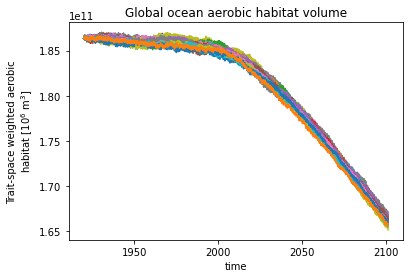

In [85]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    aero_hab_glb.sel(member_id=member_id).plot(ax=ax)
    
ax.set_title('Global ocean aerobic habitat volume');

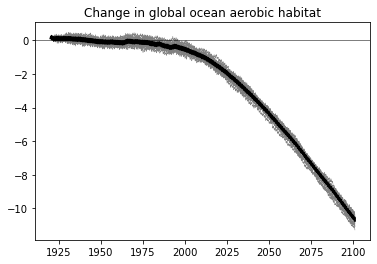

In [86]:
fig, ax = plt.subplots()

for member_id in aero_hab_glb.member_id.values:
    ax.plot(
        yrfrac, aero_hab_glb_normalized.sel(member_id=member_id), 
        linestyle='-', 
        color='gray', 
        linewidth=0.5,
    )

ax.plot(yrfrac, aero_hab_glb_normalized.mean('member_id'), '-', color='k', linewidth=2)    
ax.axhline(0., linewidth=0.5, color='k')    
ax.set_title('Change in global ocean aerobic habitat');

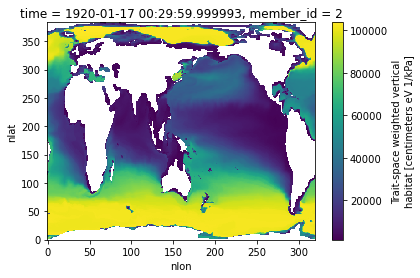

In [87]:
ds.depth_habitat_trait_wgt.isel(member_id=0, time=0).plot()

In [88]:
habitat_contraction = (
    ds.depth_habitat_trait_wgt.isel(time=tndx_2100).mean(['time', 'member_id']) -
    ds.depth_habitat_trait_wgt.isel(time=tndx_ref).mean(['time', 'member_id'])
).compute()
habitat_contraction /= 1000e2
habitat_contraction *= 100.0
habitat_contraction.attrs['long_name'] = 'Habitat change'
habitat_contraction.attrs['units'] = '%'
habitat_contraction.name = 'habitat_contraction'

habitat_contraction

<xarray.DataArray 'habitat_contraction' (nlat: 384, nlon: 320)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.09018018, -0.09017314, -0.08997496, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Habitat change
    units:      %

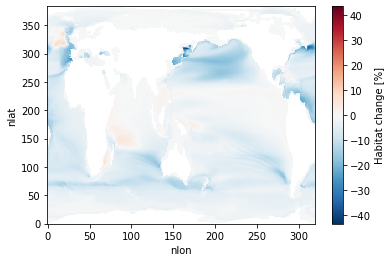

In [89]:
habitat_contraction.plot()

In [90]:
ds_plot = util.pop_add_cyclic(habitat_contraction.to_dataset())
ds_plot

<xarray.Dataset>
Dimensions:              (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                 (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    habitat_contraction  (nlat, nlon) float64 nan nan nan nan ... nan nan nan

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/glade/

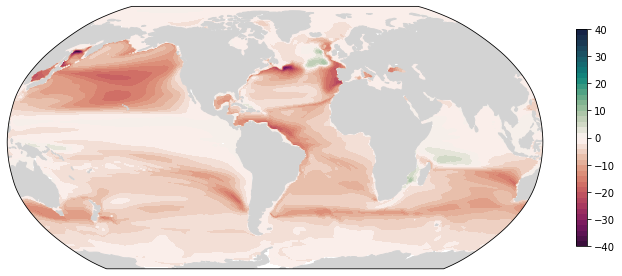

In [91]:
prj = ccrs.Robinson(central_longitude=305.0)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=prj))


cmap = cmocean.cm.curl_r

pc = ax.contourf(ds_plot.TLONG,
                 ds_plot.TLAT,
                 ds_plot.habitat_contraction,
                 levels=np.arange(-40, 42, 2),
                 cmap=cmap,
                 transform=ccrs.PlateCarree())
    
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature(
        'physical','land','110m',
        edgecolor='face',
        facecolor='lightgray'
    )
)        
plt.colorbar(pc, shrink=0.5);